In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from qec_generator import CircuitParams
from simulate_qec_rounds_stim import experiment_run
from stim_lib.scheduled_circuit import generate_scheduled
from scipy.optimize import curve_fit

## Extracting 1/Lambda with APT

In [25]:
def log_err_fit(rounds, e_logical):
    return 0.5*(1 - (1-2*e_logical)**rounds)


In [49]:
cparams = CircuitParams(t1=15e3,
                t2=10e3,
                single_qubit_gate_duration=20,
                two_qubit_gate_duration=20,
                single_qubit_depolarization_rate=1e-3,
                two_qubit_depolarization_rate=5e-3,
                meas_duration=550,
                reset_duration=None,
                reset_latency=40,
                meas_induced_dephasing_enhancement=3)


distance_vec = [3, 5]
rounds_vec = np.arange(2, 10, 2)


In [50]:

def get_error_rate_log_err_vec(reset_strategy):
#     circ, cont = generate_scheduled(
#     code_task='surface_code:rotated_memory_z',  # looks ok
#     distance=3,
#     rounds=1,
#     params=cparams
#     )
#     print(circ)
    log_err_vec = []
    error_rate = []
    task = 'surface_code:rotated_memory_z'  # looks ok
    # task = 'surface_code:unrotated_memory_z'  # looks ok

    print(cparams.reset_duration)
    for distance in distance_vec:
        error_rate.append([])
        print(f'starting distance = {distance}')
        for rounds in tqdm(rounds_vec):
            circ, cont = generate_scheduled(
                code_task='surface_code:rotated_memory_z',  # looks ok
                distance=distance,
                rounds=rounds,
                params=cparams
            )
            error_rate[-1].append(1 - experiment_run(circ, cont, shots=5000, reset_strategy=reset_strategy))
        log_err, pcov = curve_fit(log_err_fit, rounds_vec, error_rate[-1], p0=0)
        log_err_vec.append(log_err)

    log_err_vec = np.array(log_err_vec).squeeze()
    error_rate = np.array(error_rate)
    return error_rate, log_err_vec


In [51]:
cparams.reset_duration=300
error_rate_ar, log_err_vec_ar = get_error_rate_log_err_vec('AR')

  0%|          | 0/4 [00:00<?, ?it/s]

300
starting distance = 3


  0%|          | 0/4 [00:00<?, ?it/s]

starting distance = 5


100%|██████████| 4/4 [01:00<00:00, 15.05s/it]


1/Lambda = 0.9826438532028705


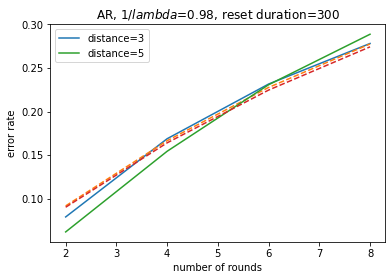

In [52]:
for i, distance in enumerate(distance_vec):
    plt.plot(rounds_vec, error_rate_ar[i], label=f'distance={distance}')
    plt.plot(rounds_vec, log_err_fit(rounds_vec, log_err_vec_ar[i]), '--')
    
plt.legend()
plt.xlabel('number of rounds')
plt.ylabel('error rate')
plt.title(f'AR, $1/lambda$={log_err_vec_ar[1] / log_err_vec_ar[0]:.2f}, reset duration={cparams.reset_duration}')
print(f'1/Lambda = {log_err_vec_ar[1] / log_err_vec_ar[0]}')


## Active parity tracking benefit

In [53]:
cparams.reset_duration=20
error_rate_apt, log_err_vec_apt = get_error_rate_log_err_vec('APT')

  0%|          | 0/4 [00:00<?, ?it/s]

20
starting distance = 3


  0%|          | 0/4 [00:00<?, ?it/s]

starting distance = 5


100%|██████████| 4/4 [00:57<00:00, 14.37s/it]


1/Lambda = 0.8437540913400294


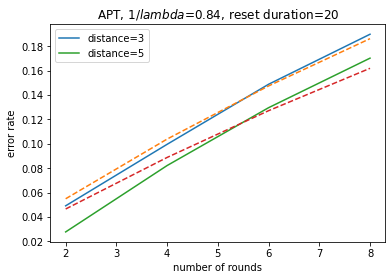

In [54]:
for i, distance in enumerate(distance_vec):
    plt.plot(rounds_vec, error_rate_apt[i], label=f'distance={distance}')
    plt.plot(rounds_vec, log_err_fit(rounds_vec, log_err_vec_apt[i]), '--')
    
plt.legend()
plt.xlabel('number of rounds')
plt.ylabel('error rate')
plt.title(f'APT, $1/lambda$={log_err_vec_apt[1] / log_err_vec_apt[0]:.2}, reset duration={cparams.reset_duration}')
print(f'1/Lambda = {log_err_vec_apt[1] / log_err_vec_apt[0]}')